<a href="https://colab.research.google.com/github/scudellerlemos/Machine-Learning-Projects/blob/Deep-Learning-(CNN)/CNN_Chest_X_Ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Instruções

O dataset utilizado para as fotos dos ferimentos/pintas se encontra no link : https://www.dropbox.com/s/8o4ysiccspp46ov/skin-cancer-mnist-ham10000.zip?e=1&dl=0

Siga as seguintes instruções abaixo:

1 - Extraia o dataset no seu Google drive e substitua seu diretorio na variavel raw_files_folder.

2 - Criar as pastas Imagens_treino,Imagens_teste,Imagens_valid.

3 - As variaveis train_folder_id,test_folder_id e validation_folder_id são nome de pastas criadas para receber imagens misturadas de forma pseudoaletoria, mantenha as strings dessas variaveis .

#Instalar Libs

In [1]:
import os
import random
from shutil import copyfile
import numpy as np
from PIL import Image
from tensorflow.keras.utils import to_categorical
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D

#Conectar no Google e Variaveis iniciais

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Variaveis Glogabais

#Arquivos
raw_files_folder = '/content/drive/My Drive/dataset_deep_learning/skin_cancer/'
local_folder_path_1 =  raw_files_folder + 'HAM10000_images_part_1/'
local_folder_path_2 =  raw_files_folder + 'HAM10000_images_part_2/'

#Nome das pastas
train_folder_id = 'Imagens_treino'
test_folder_id = 'Imagens_teste'
validation_folder_id = 'Imagens_valid'

#Amostras (mudar conforme seu ambiente aguenta)
FILES_TREINO = 5001
FILES_TESTE = 1251
FILES_VALID = 1251

#Index a serem selecionados
FILES_FILTRAR_TREINO = int(FILES_TREINO/2)
FILES_FILTRAR_TESTE = int(FILES_TESTE/2)
FILES_FILTRAR_VALID = int(FILES_VALID/2)


Mounted at /content/drive


#Aplicar Pseudoaleatoriedade entre as pastas, criar 3 pastas (treino, teste e validação) e subir as novas imagens

In [3]:
# Listar arquivos em ambas as pastas
files_1 = os.listdir(local_folder_path_1)
files_2 = os.listdir(local_folder_path_2)

In [4]:
# Filtrar os primeiros valores da lista para os conjuntos de treino
train_files_part_1 = files_1[:FILES_FILTRAR_TREINO]
train_files_part_2 = files_2[:FILES_FILTRAR_TREINO]

# Filtrar os valores finais da lista para os conjuntos de validação
validation_files_part1 = files_1[-FILES_FILTRAR_VALID:]
validation_files_part2 = files_2[-FILES_FILTRAR_VALID:]

# Calcular o índice central para os conjuntos de teste
middle_index = len(files_1) // 2

# Filtrar valores no meio da lista para os conjuntos de teste
start_index = middle_index - FILES_FILTRAR_TESTE // 2
end_index = middle_index + FILES_FILTRAR_TESTE // 2
test_files_part_1 = files_1[start_index:end_index][:FILES_TESTE]
test_files_part_2 = files_2[start_index:end_index][:FILES_TESTE]


In [5]:
# Função para fazer upload dos arquivos para uma pasta no Google Drive
def upload_files_to_drive(files, folder_id,folder_path):
    for filename in files:
        # Define o caminho completo do arquivo local
        local_file_path = os.path.join(folder_path, filename)

        # Define o caminho completo da pasta de destino no Google Drive
        dest_folder_path = os.path.join(raw_files_folder, folder_id)

        # Copia o arquivo para a pasta de destino no Google Drive
        copyfile(local_file_path, os.path.join(dest_folder_path, filename))


In [6]:
# Fazer upload das imagens para as pastas correspondentes no Google Drive
#Arquivos de treino
upload_files_to_drive(train_files_part_1, train_folder_id,local_folder_path_1)
upload_files_to_drive(train_files_part_2, train_folder_id,local_folder_path_2)

In [7]:
#Arquivos de teste
upload_files_to_drive(test_files_part_1, test_folder_id,local_folder_path_1)
upload_files_to_drive(test_files_part_2, test_folder_id,local_folder_path_2)

In [8]:
#Arquivos de validacao
upload_files_to_drive(validation_files_part1, validation_folder_id,local_folder_path_1)
upload_files_to_drive(validation_files_part2, validation_folder_id,local_folder_path_2)

#Processamento das imagens

##Listagem das imagens

In [9]:
#funcao para processamento das imagens em formato de array
def process_images_from_folder(folder_path,files):
    images = []
    for filename in os.listdir(folder_path)[:len(files)]:
        image_path = os.path.join(folder_path, filename)
        image = Image.open(image_path)
        image_array = np.array(image)
        images.append(image_array)
    return np.array(images)

In [10]:
# Pasta no Google Drive onde estão as imagens
train_folder  = raw_files_folder + train_folder_id
test_folder =  raw_files_folder + test_folder_id
validation_folder =  raw_files_folder  + validation_folder_id

# Listar os arquivos nas pastas de treino, teste e validação e remover as aspas
train_files = [os.path.splitext(file.replace('"', ''))[0] for file in os.listdir(train_folder)[:FILES_TREINO]]
test_files = [os.path.splitext(file.replace('"', ''))[0] for file in os.listdir(test_folder)[:FILES_TESTE]]
valid_files = [os.path.splitext(file.replace('"', ''))[0] for file in os.listdir(validation_folder)[:FILES_VALID]]


##Processamento inicial das features de treino, validação e teste

In [11]:
# Processar as imagens de cada pasta
x_train = process_images_from_folder(train_folder,train_files)
x_validation = process_images_from_folder(validation_folder,valid_files)
x_test = process_images_from_folder(test_folder,test_files)


###Imagem colorida contendo mais dimensoes, conventendo para apenas 1d (features) // redimensonar para 50x50 devido ao tamanho da imagem

In [12]:
# Redimensionar as imagens para 46x32 pixels
def resize_images(images):
    resized_images = []
    for img in images:
        resized_img = np.array(Image.fromarray(img).resize((50, 50)))
        resized_images.append(resized_img)
    return np.array(resized_images)

# Redimensionar as imagens de treino, validação e teste
x_train_resized = resize_images(x_train)
x_validation_resized = resize_images(x_validation)
x_test_resized = resize_images(x_test)


In [13]:
x_train_resized.shape

(5000, 50, 50, 3)

In [14]:
# Achatando as imagens para um array unidimensional
x_train_flat = x_train_resized.reshape(x_train_resized.shape[0], -1)
x_validation_flat = x_validation_resized.reshape(x_validation_resized.shape[0], -1)
x_test_flat = x_test_resized.reshape(x_test_resized.shape[0], -1)

In [15]:
# Criando DataFrames com os arrays unidimensionais
df_train_pixels = pd.DataFrame(x_train_flat, columns=[f'pixel_{i}' for i in range(x_train_flat.shape[1])])
df_validation_pixels = pd.DataFrame(x_validation_flat, columns=[f'pixel_{i}' for i in range(x_validation_flat.shape[1])])
df_test_pixels = pd.DataFrame(x_test_flat, columns=[f'pixel_{i}' for i in range(x_test_flat.shape[1])])


In [16]:
# Verificando a forma dos DataFrames resultantes
print("Shape do DataFrame de treino:", df_train_pixels.shape)
print("Shape do DataFrame de validação:", df_validation_pixels.shape)
print("Shape do DataFrame de teste:", df_test_pixels.shape)

Shape do DataFrame de treino: (5000, 7500)
Shape do DataFrame de validação: (1250, 7500)
Shape do DataFrame de teste: (1248, 7500)


In [17]:
df_train_pixels['image_id']= train_files
df_validation_pixels['image_id']= valid_files
df_test_pixels['image_id']= test_files

##Processamento das Labels [é cancer, não é cancer]

In [18]:
# Consumir os metadados
dataset_path = raw_files_folder + 'HAM10000_metadata.csv'
metadados = pd.read_csv(dataset_path)
metadados_dx = metadados[['image_id', 'dx']].copy()

# Lista de valores que indicam "não é câncer"
nao_cancer = ['akiec', 'nv', 'bkl']

####'akiec': Queratose actínica / Carcinoma intraepitelial escamoso de células escamosas (CIECE)
####'nv': Nevo melanocítico
####'bkl': Lesão benigna da queratose (Benign keratosis-like lesions)

# Criar a nova coluna "dx_rede" com a regra de cancer e não cancer
metadados_dx['dx_rede'] = metadados_dx['dx'].copy().apply(lambda x: 'não é câncer' if x in nao_cancer else 'é câncer')

df_target = metadados_dx[['image_id','dx_rede']].copy()


###Criação das Labels de arquivo com os arquivos das pastas de treino e teste

In [19]:
# Filtrar o DataFrame para cada conjunto
df_train_filtered = df_target[df_target['image_id'].isin(train_files)]
df_test_filtered = df_target[df_target['image_id'].isin(test_files)]
df_valid_filtered = df_target[df_target['image_id'].isin(valid_files)]

In [20]:
# Garantir que os IDs das imagens estão no mesmo formato em ambos os DataFrames
df_train_filtered['image_id'] = df_train_filtered['image_id'].copy().apply(lambda x: os.path.splitext(x)[0])
df_valid_filtered['image_id'] = df_valid_filtered['image_id'].copy().apply(lambda x: os.path.splitext(x)[0])
df_test_filtered['image_id'] = df_test_filtered['image_id'].copy().apply(lambda x: os.path.splitext(x)[0])


<ipython-input-20-20554f2a2e15>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_filtered['image_id'] = df_train_filtered['image_id'].copy().apply(lambda x: os.path.splitext(x)[0])
<ipython-input-20-20554f2a2e15>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid_filtered['image_id'] = df_valid_filtered['image_id'].copy().apply(lambda x: os.path.splitext(x)[0])
<ipython-input-20-20554f2a2e15>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try u

###Criação do dataset processado com as imagens e labels definindo por imagem o que é cancerigeno e o que não é

In [21]:
# Unir os DataFrames de pixels com os DataFrames de metadados usando a coluna 'image_id'
df_train_merged = pd.merge(df_train_pixels, df_train_filtered, on='image_id')
df_validation_merged = pd.merge(df_validation_pixels, df_valid_filtered, on='image_id')
df_test_merged = pd.merge(df_test_pixels, df_test_filtered, on='image_id')

df_train_true = df_train_merged.drop('image_id',axis = 1)
df_test_true = df_test_merged.drop('image_id',axis = 1)
df_validation_true = df_validation_merged.drop('image_id',axis = 1)

In [22]:
#Mudar nome de coluna de "dx_rede" para "label"
df_train_true.rename(columns={'dx_rede': 'label'}, inplace=True)
df_test_true.rename(columns={'dx_rede': 'label'}, inplace=True)
df_validation_true.rename(columns={'dx_rede': 'label'}, inplace=True)

In [23]:
df_train_true.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_7491,pixel_7492,pixel_7493,pixel_7494,pixel_7495,pixel_7496,pixel_7497,pixel_7498,pixel_7499,label
0,179,151,177,181,152,178,184,156,179,185,...,193,162,177,190,158,176,187,157,174,não é câncer
1,57,37,40,96,72,75,128,106,105,143,...,111,80,83,82,49,56,45,27,32,é câncer
2,3,3,1,6,5,3,8,8,5,17,...,135,106,111,129,103,103,127,104,103,não é câncer
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,não é câncer
4,213,199,200,219,204,206,225,210,214,229,...,225,206,211,221,202,207,219,199,206,não é câncer


In [24]:
df_test_true.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_7491,pixel_7492,pixel_7493,pixel_7494,pixel_7495,pixel_7496,pixel_7497,pixel_7498,pixel_7499,label
0,233,149,171,232,148,172,237,152,175,237,...,221,143,153,219,142,157,220,146,160,não é câncer
1,239,176,181,241,176,182,240,175,182,241,...,228,177,175,227,177,175,225,177,174,não é câncer
2,182,153,163,191,161,170,197,165,172,200,...,207,168,176,202,158,162,199,150,149,é câncer
3,233,158,172,236,160,174,237,157,173,238,...,232,163,173,230,161,171,228,162,171,não é câncer
4,153,123,123,168,140,148,179,154,167,182,...,170,144,143,162,137,134,154,131,134,é câncer


In [25]:
df_validation_true.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_7491,pixel_7492,pixel_7493,pixel_7494,pixel_7495,pixel_7496,pixel_7497,pixel_7498,pixel_7499,label
0,223,158,158,225,161,163,225,162,163,226,...,212,149,145,212,150,148,209,148,143,não é câncer
1,191,169,180,191,169,180,195,176,190,201,...,180,163,179,177,159,174,176,159,175,não é câncer
2,236,181,178,235,184,183,237,187,188,239,...,235,171,170,234,164,160,234,164,162,é câncer
3,212,131,129,214,133,133,215,130,129,216,...,204,134,129,204,136,135,200,137,131,não é câncer
4,183,116,105,185,121,110,193,140,143,196,...,171,120,125,156,111,118,136,90,95,não é câncer


In [26]:
df_train_true.shape

(5000, 7501)

In [27]:
df_test_true.shape

(1248, 7501)

In [28]:
df_validation_true.shape

(1250, 7501)

# Normalização do dataset e mapeamento do target (num_class)

In [29]:
# Fazer mapping para trocar string por numeros
label_dict = {'é câncer':1,'não é câncer':0}

df_train_true_label = df_train_true.copy()
df_train_true_label['label'] = df_train_true_label['label'].map(label_dict)

df_test_true_label = df_test_true.copy()
df_test_true_label['label'] = df_test_true_label['label'].map(label_dict)

df_validation_true_label = df_validation_true.copy()
df_validation_true_label['label'] = df_validation_true_label['label'].map(label_dict)


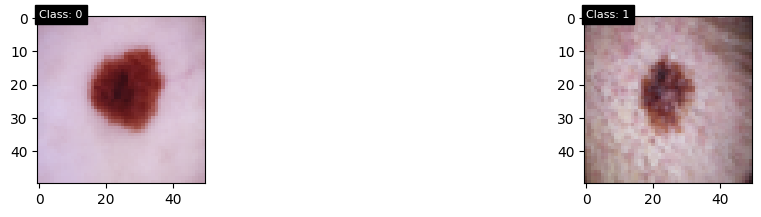

In [30]:
# Obter as classes únicas do conjunto de dados
classes = set(df_train_true_label['label'])

plt.figure(0, figsize=(20,10))

# Iterar sobre cada classe
for c in classes:
    idx = np.where(df_train_true_label['label'] == c)
    if c + 1 == 10:
        break
    plt.subplot(430 + 1 +c)
    plt.imshow(df_train_true_label.drop('label', axis=1).iloc[idx[0][0]].values.reshape((50, 50, 3)))
    plt.text(0, 0, f'Class: {c}', color='white', backgroundcolor='black', fontsize=8)

plt.show()


# Normalização do dataset e mapeamento do target (num_class)

In [31]:

#Extração dos dfs de treino,teste e valição e suas respectivas labels
x_train = df_train_true_label.drop('label',axis=1).values
y_train = df_train_true_label['label'].values

x_test = df_test_true_label.drop('label',axis=1).values
y_test = df_test_true_label['label'].values

x_valid = df_validation_true_label.drop('label',axis=1).values
y_valid = df_validation_true_label['label'].values


In [32]:
#Normalização das features, colocando-as entre 0 e 1
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_valid = x_valid.astype('float32') / 255

In [33]:
x_train

array([[0.7019608 , 0.5921569 , 0.69411767, ..., 0.73333335, 0.6156863 ,
        0.68235296],
       [0.22352941, 0.14509805, 0.15686275, ..., 0.1764706 , 0.10588235,
        0.1254902 ],
       [0.01176471, 0.01176471, 0.00392157, ..., 0.49803922, 0.40784314,
        0.40392157],
       ...,
       [0.8980392 , 0.65882355, 0.70980394, ..., 0.84705883, 0.65882355,
        0.64705884],
       [0.8117647 , 0.7254902 , 0.69803923, ..., 0.56078434, 0.43529412,
        0.39215687],
       [0.93333334, 0.6156863 , 0.6862745 , ..., 0.7372549 , 0.39607844,
        0.41960785]], dtype=float32)

In [34]:
x_test

array([[0.9137255 , 0.58431375, 0.67058825, ..., 0.8627451 , 0.57254905,
        0.627451  ],
       [0.9372549 , 0.6901961 , 0.70980394, ..., 0.88235295, 0.69411767,
        0.68235296],
       [0.7137255 , 0.6       , 0.6392157 , ..., 0.78039217, 0.5882353 ,
        0.58431375],
       ...,
       [0.63529414, 0.47058824, 0.49803922, ..., 0.65882355, 0.49803922,
        0.5254902 ],
       [0.70980394, 0.53333336, 0.5529412 , ..., 0.6039216 , 0.3882353 ,
        0.43529412],
       [0.5372549 , 0.4392157 , 0.4509804 , ..., 0.6039216 , 0.53333336,
        0.53333336]], dtype=float32)

In [35]:
x_valid

array([[0.8745098 , 0.61960787, 0.61960787, ..., 0.81960785, 0.5803922 ,
        0.56078434],
       [0.7490196 , 0.6627451 , 0.7058824 , ..., 0.6901961 , 0.62352943,
        0.6862745 ],
       [0.9254902 , 0.70980394, 0.69803923, ..., 0.91764706, 0.6431373 ,
        0.63529414],
       ...,
       [0.8352941 , 0.7490196 , 0.84705883, ..., 0.8117647 , 0.72156864,
        0.7921569 ],
       [0.6745098 , 0.46666667, 0.44313726, ..., 0.7529412 , 0.60784316,
        0.59607846],
       [0.16078432, 0.08235294, 0.09411765, ..., 0.21960784, 0.11764706,
        0.11764706]], dtype=float32)

In [36]:
# Número de pixels por imagem
num_pixels = 7500  # Ou seja, 50x50x3

# Redimensionar os dados para tensores 3D
x_train_3d = x_train.reshape(x_train.shape[0], 50, 50, 3)
x_test_3d = x_test.reshape(x_test.shape[0], 50, 50, 3)
x_valid_3d = x_valid.reshape(x_valid.shape[0], 50, 50, 3)


In [37]:
x_train.shape[0]

5000

In [38]:
x_valid.shape[0]

1250

In [39]:
x_test.shape[0]

1248

In [40]:
# Convertendo os rótulos verdadeiros para codificação one-hot
y_train_one_hot = to_categorical(y_train, len(classes))
y_test_one_hot = to_categorical(y_test, len(classes))
y_valid_one_hot = to_categorical(y_valid, len(classes))

In [41]:
len(y_valid_one_hot)

1250

# Arquitetura da Rede Neural e Treino

In [42]:

# Definir o modelo
model = Sequential()

# Primeira camada convolucional
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(50, 50, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))


# Segunda camada convolucional
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(50, 50, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Camada Flatten
model.add(Flatten())

# Camada densa
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.25))

# Camada de saída
model.add(Dense(2, activation='softmax'))




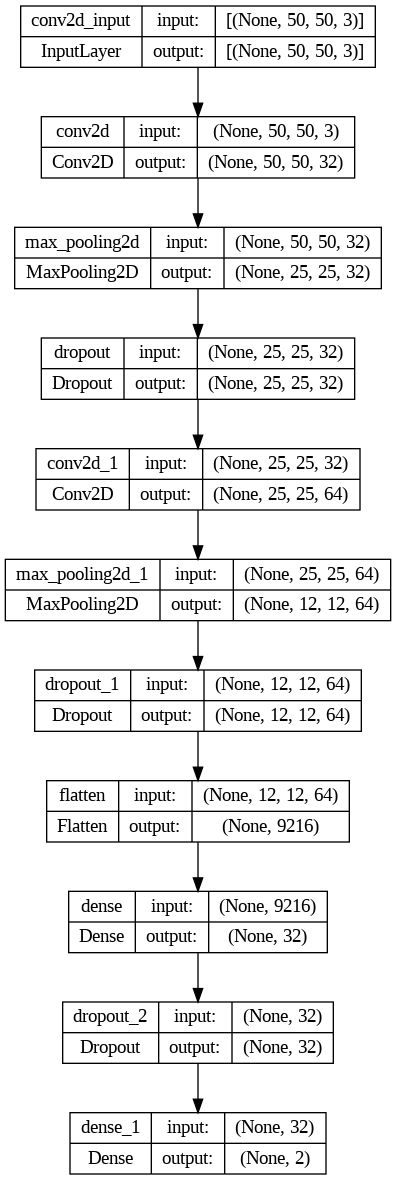

In [43]:
from keras.utils import plot_model
# Plotar o modelo
plot_model(model, to_file='cnn-CHEST_X_RAY.png', show_shapes=True, show_layer_names=True)


In [44]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 25, 25, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 64)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 64)        0

In [45]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [46]:
from keras.callbacks import ModelCheckpoint

In [47]:
checkpointer = ModelCheckpoint(filepath='/content/drive/My Drive/modelos/CHEST_X_RAY.hdf5', verbose=1,  save_best_only=True, monitor='val_accuracy') #

hist = model.fit(x_train_3d, y_train_one_hot, batch_size=200, epochs=5, validation_data=(x_valid_3d, y_valid_one_hot), callbacks=[checkpointer], verbose=1, shuffle=True)

Epoch 1/5
25/25 [==============================] - ETA: 0s - loss: 0.6523 - accuracy: 0.7338
Epoch 1: val_accuracy improved from -inf to 0.84240, saving model to /content/drive/My Drive/modelos/CHEST_X_RAY.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 22s 838ms/step - loss: 0.6523 - accuracy: 0.7338 - val_loss: 0.5306 - val_accuracy: 0.8424
Epoch 2/5
25/25 [==============================] - ETA: 0s - loss: 0.5038 - accuracy: 0.7886
Epoch 2: val_accuracy did not improve from 0.84240
25/25 [==============================] - 22s 877ms/step - loss: 0.5038 - accuracy: 0.7886 - val_loss: 0.5128 - val_accuracy: 0.8424
Epoch 3/5
25/25 [==============================] - ETA: 0s - loss: 0.4883 - accuracy: 0.7886
Epoch 3: val_accuracy did not improve from 0.84240
25/25 [==============================] - 19s 768ms/step - loss: 0.4883 - accuracy: 0.7886 - val_loss: 0.4438 - val_accuracy: 0.8424
Epoch 4/5
25/25 [==============================] - ETA: 0s - loss: 0.4769 - accuracy: 0.7886
Epoch 4: val_accuracy did not improve from 0.84240
25/25 [==============================] - 20s 820ms/step - loss: 0.4769 - accuracy: 0.7886 - val_loss: 0.4586 - val_accuracy: 0.8424
Epoch 5/5
25/25 [=======================

# Mostrar os resultados

In [48]:
model = load_model("/content/drive/My Drive/modelos/CHEST_X_RAY.hdf5")

In [49]:
score = model.evaluate(x_test_3d, y_test_one_hot, verbose=0)
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.8413461446762085


In [50]:
y_pred = model.predict(x_test_3d)

39/39 [==============================] - 1s 29ms/step


In [51]:
len(y_pred)

1248

In [52]:
y_test_one_hot

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

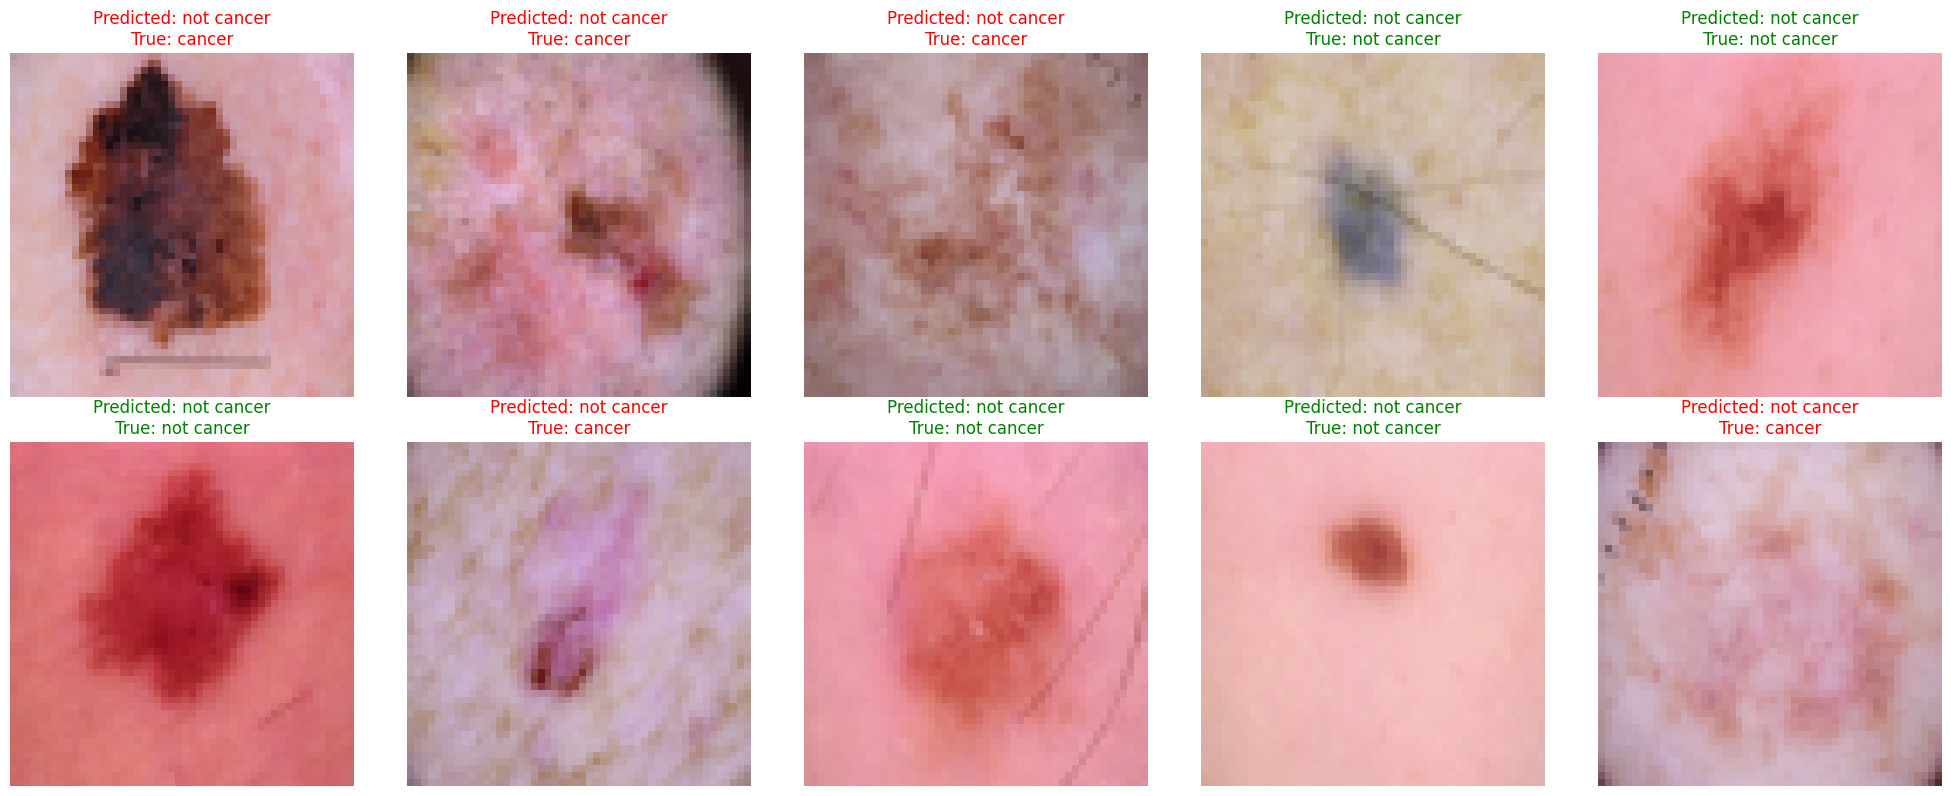

In [53]:
labels = ['not cancer', 'cancer']
# Inicializar listas para armazenar os índices selecionados para cada classe
indices_classe_0 = []
indices_classe_1 = []

# Iterar sobre os índices do conjunto de teste
for idx in range(len(y_test_one_hot)):
    # Verificar a classe da amostra correspondente ao índice
    if np.argmax(y_test_one_hot[idx]) == 0 and len(indices_classe_0) < 5:
        indices_classe_0.append(idx)
    elif np.argmax(y_test_one_hot[idx]) == 1 and len(indices_classe_1) < 5:
        indices_classe_1.append(idx)

    # Verificar se já temos amostras suficientes de ambas as classes
    if len(indices_classe_0) >= 5 and len(indices_classe_1) >= 5:
        break

# Selecionar 5 índices de cada classe
indices_selecionados = indices_classe_0 + indices_classe_1

# Embaralhar os índices selecionados
np.random.shuffle(indices_selecionados)

# Plotar as imagens correspondentes aos índices selecionados
fig = plt.figure(figsize=(20, 8))
for i, idx in enumerate(indices_selecionados):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(np.squeeze(x_test_3d[idx]))
    pred_label = labels[np.argmax(y_pred[idx])]
    true_label = labels[np.argmax(y_test_one_hot[idx])]
    ax.set_title(f'Predicted: {pred_label}\nTrue: {true_label}', color=("green" if pred_label == true_label else "red"))
    ax.axis('off')

plt.tight_layout()
plt.show()


In [54]:
y_test_one_hot

array([[1., 0.],
       [1., 0.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [55]:
y_pred

array([[0.6529463 , 0.34705368],
       [0.6653062 , 0.33469376],
       [0.64168584, 0.3583141 ],
       ...,
       [0.6467037 , 0.3532964 ],
       [0.63194346, 0.36805654],
       [0.63366395, 0.3663361 ]], dtype=float32)